# Data Exploration - Indonesian License Plate Dataset

This notebook analyzes the Indonesian license plate dataset characteristics and quality.

## Tasks:
- [ ] Load and examine dataset structure
- [ ] Visualize sample images with annotations
- [ ] Analyze Indonesian license plate patterns
- [ ] Check annotation quality and consistency
- [ ] Identify data issues (missing labels, corrupt images)
- [ ] Generate statistics: image sizes, aspect ratios, label distributions
- [ ] Create data quality report

## 1. Import Libraries and Setup

In [9]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image, ImageDraw, ImageFont
import yaml
import json
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")
print(f"Working directory: {os.getcwd()}")

Libraries imported successfully
Working directory: c:\Users\Rafael Jonathan\Desktop\license-plate-training


## 2. Dataset Path Configuration

In [10]:
# Dataset paths (adjust based on your download structure)
BASE_DIR = Path("..")
DATASET_RAW = BASE_DIR / "dataset" / "raw"

# Common dataset folder names from Roboflow
possible_dataset_folders = [
    "plat-kendaraan",  # Your actual dataset folder
    "Indonesia-License-Plate-2",
    "indonesia-license-plate-iqrtj", 
    "Indonesia-License-Plate",
    "dataset"
]

# Find the actual dataset folder
DATASET_PATH = None
if DATASET_RAW.exists():
    print(f"Looking in raw directory: {DATASET_RAW}")
    print("Available folders:")
    for item in DATASET_RAW.iterdir():
        if item.is_dir():
            print(f"  📁 {item.name}/")
    
    for folder in possible_dataset_folders:
        potential_path = DATASET_RAW / folder
        if potential_path.exists():
            DATASET_PATH = potential_path
            print(f"✅ Found dataset folder: {folder}")
            break
    
    # If no specific folder found, check if files are directly in raw
    if DATASET_PATH is None:
        yaml_files = list(DATASET_RAW.glob("*.yaml"))
        if yaml_files:
            DATASET_PATH = DATASET_RAW
            print("✅ Using raw directory directly (YAML found)")
        else:
            # Try to auto-detect any folder with train/valid structure
            for item in DATASET_RAW.iterdir():
                if item.is_dir():
                    train_path = item / "train"
                    valid_path = item / "valid"
                    if train_path.exists() or valid_path.exists():
                        DATASET_PATH = item
                        print(f"✅ Auto-detected dataset folder: {item.name}")
                        break
else:
    print(f"❌ Raw directory does not exist: {DATASET_RAW}")

print(f"\nDataset raw directory: {DATASET_RAW}")
print(f"Dataset path: {DATASET_PATH}")
print(f"Dataset exists: {DATASET_PATH.exists() if DATASET_PATH else False}")

if DATASET_PATH and DATASET_PATH.exists():
    print("\nDataset contents:")
    for item in DATASET_PATH.iterdir():
        if item.is_dir():
            file_count = len(list(item.rglob("*.*")))
            print(f"  📁 {item.name}/ ({file_count} files)")
        else:
            print(f"  📄 {item.name}")
else:
    print("\n⚠️  Dataset not found. Please run notebook 01 to download the dataset first.")

Looking in raw directory: ..\dataset\raw
Available folders:
  📁 plat-kendaraan/
✅ Found dataset folder: plat-kendaraan

Dataset raw directory: ..\dataset\raw
Dataset path: ..\dataset\raw\plat-kendaraan
Dataset exists: True

Dataset contents:
  📄 data.yaml
  📄 README.dataset.txt
  📄 README.roboflow.txt
  📁 test/ (42 files)
  📁 train/ (10200 files)
  📁 valid/ (864 files)


## 3. Load Dataset Configuration

In [11]:
# Load YAML configuration if available
dataset_config = None
yaml_file = None

if DATASET_PATH and DATASET_PATH.exists():
    # Look for YAML files
    yaml_files = list(DATASET_PATH.glob("*.yaml")) + list(DATASET_PATH.glob("data.yaml"))
    
    if yaml_files:
        yaml_file = yaml_files[0]
        print(f"Found YAML config: {yaml_file.name}")
        
        with open(yaml_file, 'r') as f:
            dataset_config = yaml.safe_load(f)
        
        print("\nDataset Configuration:")
        print("=" * 30)
        for key, value in dataset_config.items():
            print(f"{key}: {value}")
    else:
        print("No YAML configuration file found")
        
        # Try to infer structure
        splits = ['train', 'valid', 'test', 'val']
        found_splits = []
        for split in splits:
            split_path = DATASET_PATH / split
            if split_path.exists():
                found_splits.append(split)
        
        if found_splits:
            print(f"Inferred dataset splits: {found_splits}")
            
            # Create basic config
            dataset_config = {
                'path': str(DATASET_PATH),
                'train': found_splits[0] if 'train' in found_splits else found_splits[0],
                'val': 'valid' if 'valid' in found_splits else ('val' if 'val' in found_splits else found_splits[-1]),
                'test': 'test' if 'test' in found_splits else None,
                'names': ['plate', 'vehicle']  # Assumed based on dataset research
            }
else:
    print("Dataset path not available for configuration loading")

Found YAML config: data.yaml

Dataset Configuration:
names: ['License_Plate']
nc: 1
roboflow: {'license': 'MIT', 'project': 'vehicle-and-license-plate', 'url': 'https://universe.roboflow.com/plat-kendaraan/vehicle-and-license-plate/dataset/1', 'version': 1, 'workspace': 'plat-kendaraan'}
test: ../test/images
train: ../train/images
val: ../valid/images


## 4. Dataset Structure Analysis

In [12]:
def analyze_dataset_structure(dataset_path):
    """Analyze the structure and content of the dataset"""
    if not dataset_path or not dataset_path.exists():
        print("Dataset path not available")
        return None
    
    analysis = {
        'splits': {},
        'total_images': 0,
        'total_labels': 0,
        'image_formats': Counter(),
        'issues': []
    }
    
    # Define possible split names
    split_names = ['train', 'valid', 'val', 'test']
    
    for split_name in split_names:
        split_path = dataset_path / split_name
        if not split_path.exists():
            continue
            
        images_path = split_path / 'images'
        labels_path = split_path / 'labels'
        
        split_info = {
            'images': 0,
            'labels': 0,
            'image_files': [],
            'label_files': [],
            'missing_labels': [],
            'missing_images': []
        }
        
        # Count images
        if images_path.exists():
            image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
            for ext in image_extensions:
                files = list(images_path.glob(f'*{ext}')) + list(images_path.glob(f'*{ext.upper()}'))
                split_info['image_files'].extend(files)
                
                # Count formats
                for file in files:
                    analysis['image_formats'][ext.lower()] += 1
        
        split_info['images'] = len(split_info['image_files'])
        
        # Count labels
        if labels_path.exists():
            label_files = list(labels_path.glob('*.txt'))
            split_info['label_files'] = label_files
            split_info['labels'] = len(label_files)
        
        # Check for missing pairs
        image_stems = {f.stem for f in split_info['image_files']}
        label_stems = {f.stem for f in split_info['label_files']}
        
        split_info['missing_labels'] = list(image_stems - label_stems)
        split_info['missing_images'] = list(label_stems - image_stems)
        
        if split_info['missing_labels']:
            analysis['issues'].append(f"{split_name}: {len(split_info['missing_labels'])} images without labels")
        
        if split_info['missing_images']:
            analysis['issues'].append(f"{split_name}: {len(split_info['missing_images'])} labels without images")
        
        analysis['splits'][split_name] = split_info
        analysis['total_images'] += split_info['images']
        analysis['total_labels'] += split_info['labels']
    
    return analysis

# Run analysis
structure_analysis = analyze_dataset_structure(DATASET_PATH)

if structure_analysis:
    print("📊 Dataset Structure Analysis")
    print("=" * 40)
    print(f"Total Images: {structure_analysis['total_images']}")
    print(f"Total Labels: {structure_analysis['total_labels']}")
    print(f"Image Formats: {dict(structure_analysis['image_formats'])}")
    
    print("\n📁 Split Breakdown:")
    for split_name, split_info in structure_analysis['splits'].items():
        print(f"  {split_name.upper()}:")
        print(f"    Images: {split_info['images']}")
        print(f"    Labels: {split_info['labels']}")
        print(f"    Match Rate: {split_info['labels']/split_info['images']*100:.1f}%" if split_info['images'] > 0 else "    Match Rate: N/A")
    
    if structure_analysis['issues']:
        print("\n⚠️  Issues Found:")
        for issue in structure_analysis['issues']:
            print(f"  - {issue}")
    else:
        print("\n✅ No structural issues found")
else:
    print("Cannot analyze dataset structure - dataset not available")

📊 Dataset Structure Analysis
Total Images: 11106
Total Labels: 5553
Image Formats: {'.jpg': 11106}

📁 Split Breakdown:
  TRAIN:
    Images: 10200
    Labels: 5100
    Match Rate: 50.0%
  VALID:
    Images: 864
    Labels: 432
    Match Rate: 50.0%
  TEST:
    Images: 42
    Labels: 21
    Match Rate: 50.0%

✅ No structural issues found


## 5. Sample Image Visualization

In [13]:
def load_yolo_annotations(label_file, img_width, img_height):
    """Load YOLO format annotations and convert to pixel coordinates"""
    annotations = []
    
    if not label_file.exists():
        return annotations
    
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                
                # Convert to pixel coordinates
                x1 = int((x_center - width/2) * img_width)
                y1 = int((y_center - height/2) * img_height)
                x2 = int((x_center + width/2) * img_width)
                y2 = int((y_center + height/2) * img_height)
                
                annotations.append({
                    'class_id': class_id,
                    'bbox': [x1, y1, x2, y2],
                    'center': [x_center, y_center],
                    'size': [width, height]
                })
    
    return annotations

def visualize_sample_images(dataset_path, dataset_config, num_samples=6):
    """Visualize sample images with their annotations"""
    if not dataset_path or not dataset_path.exists():
        print("Dataset not available for visualization")
        return
    
    # Get class names
    class_names = dataset_config.get('names', ['class_0', 'class_1']) if dataset_config else ['plate', 'vehicle']
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']
    
    # Find images from train split
    train_split = 'train'
    if dataset_config and 'train' in dataset_config:
        train_split = dataset_config['train']
    
    images_path = dataset_path / train_split / 'images'
    labels_path = dataset_path / train_split / 'labels'
    
    if not images_path.exists():
        print(f"Images path not found: {images_path}")
        return
    
    # Get sample images
    image_files = list(images_path.glob('*.jpg')) + list(images_path.glob('*.png'))
    
    if len(image_files) == 0:
        print("No image files found")
        return
    
    # Randomly sample images
    np.random.seed(42)
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    # Create subplot
    rows = 2
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(sample_files):
        if idx >= len(axes):
            break
            
        # Load image
        img = cv2.imread(str(img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_height, img_width = img.shape[:2]
        
        # Load corresponding label
        label_file = labels_path / f"{img_file.stem}.txt"
        annotations = load_yolo_annotations(label_file, img_width, img_height)
        
        # Draw annotations
        img_annotated = img.copy()
        for ann in annotations:
            x1, y1, x2, y2 = ann['bbox']
            class_id = ann['class_id']
            
            # Draw bounding box
            color = colors[class_id % len(colors)]
            cv2.rectangle(img_annotated, (x1, y1), (x2, y2), 
                         plt.colors.to_rgb(color), 2)
            
            # Add class label
            class_name = class_names[class_id] if class_id < len(class_names) else f'class_{class_id}'
            cv2.putText(img_annotated, class_name, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, plt.colors.to_rgb(color), 2)
        
        # Display
        axes[idx].imshow(img_annotated)
        axes[idx].set_title(f"{img_file.name}\n{len(annotations)} objects", fontsize=10)
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(sample_files), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Images with Annotations', fontsize=16, y=1.02)
    plt.show()
    
    print(f"\nSample Analysis:")
    print(f"Displaying {len(sample_files)} sample images")
    print(f"Class names: {class_names}")

# Run visualization
visualize_sample_images(DATASET_PATH, dataset_config)

Images path not found: ..\dataset\raw\plat-kendaraan\..\train\images\images


## 6. Image Statistics Analysis

In [14]:
def analyze_image_statistics(dataset_path, max_samples=200):
    """Analyze image dimensions, aspect ratios, and file sizes"""
    if not dataset_path or not dataset_path.exists():
        print("Dataset not available for image analysis")
        return None
    
    stats = {
        'widths': [],
        'heights': [],
        'aspect_ratios': [],
        'file_sizes': [],
        'areas': [],
        'splits': {}
    }
    
    split_names = ['train', 'valid', 'val', 'test']
    
    for split_name in split_names:
        images_path = dataset_path / split_name / 'images'
        if not images_path.exists():
            continue
        
        image_files = list(images_path.glob('*.jpg')) + list(images_path.glob('*.png'))
        
        # Sample images if too many
        if len(image_files) > max_samples:
            np.random.seed(42)
            image_files = np.random.choice(image_files, max_samples, replace=False)
        
        split_stats = {
            'widths': [],
            'heights': [],
            'aspect_ratios': [],
            'file_sizes': [],
            'areas': []
        }
        
        print(f"Analyzing {len(image_files)} images from {split_name} split...")
        
        for img_file in image_files:
            try:
                # Get file size
                file_size = img_file.stat().st_size / 1024  # KB
                
                # Get image dimensions
                with Image.open(img_file) as img:
                    width, height = img.size
                    aspect_ratio = width / height
                    area = width * height
                    
                    # Store in both overall and split stats
                    for storage in [stats, split_stats]:
                        storage['widths'].append(width)
                        storage['heights'].append(height)
                        storage['aspect_ratios'].append(aspect_ratio)
                        storage['file_sizes'].append(file_size)
                        storage['areas'].append(area)
                        
            except Exception as e:
                print(f"Error processing {img_file}: {e}")
                continue
        
        stats['splits'][split_name] = split_stats
    
    return stats

# Run image statistics analysis
image_stats = analyze_image_statistics(DATASET_PATH)

if image_stats and len(image_stats['widths']) > 0:
    print("\n📐 Image Statistics Summary")
    print("=" * 40)
    
    # Overall statistics
    print(f"Total analyzed images: {len(image_stats['widths'])}")
    print(f"\nDimensions:")
    print(f"  Width  - Min: {min(image_stats['widths'])}, Max: {max(image_stats['widths'])}, Avg: {np.mean(image_stats['widths']):.0f}")
    print(f"  Height - Min: {min(image_stats['heights'])}, Max: {max(image_stats['heights'])}, Avg: {np.mean(image_stats['heights']):.0f}")
    
    print(f"\nAspect Ratios:")
    print(f"  Min: {min(image_stats['aspect_ratios']):.2f}, Max: {max(image_stats['aspect_ratios']):.2f}, Avg: {np.mean(image_stats['aspect_ratios']):.2f}")
    
    print(f"\nFile Sizes (KB):")
    print(f"  Min: {min(image_stats['file_sizes']):.1f}, Max: {max(image_stats['file_sizes']):.1f}, Avg: {np.mean(image_stats['file_sizes']):.1f}")
    
    # Most common dimensions
    dimensions = [(w, h) for w, h in zip(image_stats['widths'], image_stats['heights'])]
    dim_counter = Counter(dimensions)
    print(f"\nMost common dimensions:")
    for (w, h), count in dim_counter.most_common(5):
        print(f"  {w}x{h}: {count} images ({count/len(dimensions)*100:.1f}%)")
else:
    print("No image statistics available - dataset not loaded")

Analyzing 200 images from train split...
Analyzing 200 images from valid split...
Analyzing 21 images from test split...

📐 Image Statistics Summary
Total analyzed images: 421

Dimensions:
  Width  - Min: 640, Max: 640, Avg: 640
  Height - Min: 640, Max: 640, Avg: 640

Aspect Ratios:
  Min: 1.00, Max: 1.00, Avg: 1.00

File Sizes (KB):
  Min: 11.6, Max: 103.0, Avg: 61.8

Most common dimensions:
  640x640: 421 images (100.0%)


## 7. Create Visualization Plots

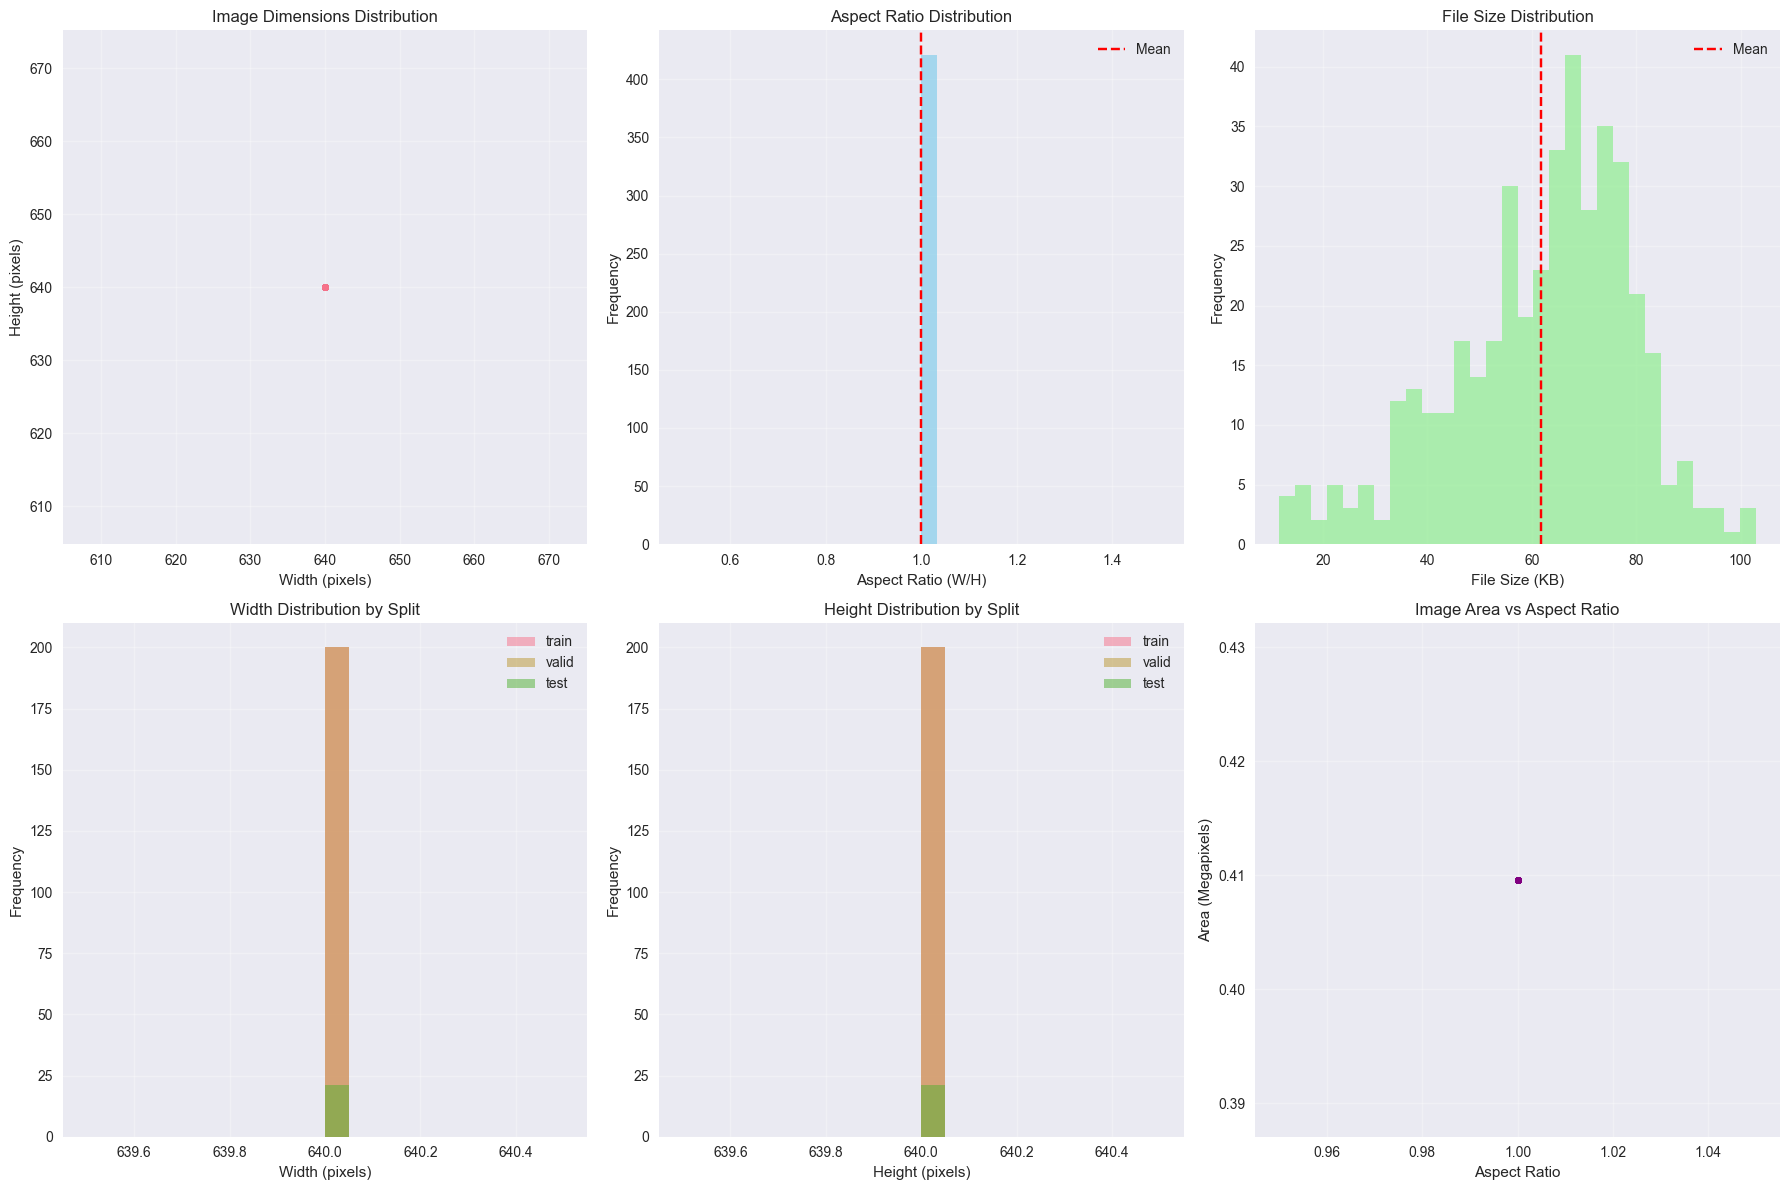


Plots saved to: ..\results\plots\image_statistics_analysis.png


<Figure size 800x550 with 0 Axes>

In [15]:
def create_statistics_plots(image_stats):
    """Create comprehensive plots for image statistics"""
    if not image_stats or len(image_stats['widths']) == 0:
        print("No data available for plotting")
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Image dimensions scatter plot
    axes[0,0].scatter(image_stats['widths'], image_stats['heights'], alpha=0.6, s=20)
    axes[0,0].set_xlabel('Width (pixels)')
    axes[0,0].set_ylabel('Height (pixels)')
    axes[0,0].set_title('Image Dimensions Distribution')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Aspect ratio histogram
    axes[0,1].hist(image_stats['aspect_ratios'], bins=30, alpha=0.7, color='skyblue')
    axes[0,1].axvline(np.mean(image_stats['aspect_ratios']), color='red', linestyle='--', label='Mean')
    axes[0,1].set_xlabel('Aspect Ratio (W/H)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Aspect Ratio Distribution')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. File size histogram
    axes[0,2].hist(image_stats['file_sizes'], bins=30, alpha=0.7, color='lightgreen')
    axes[0,2].axvline(np.mean(image_stats['file_sizes']), color='red', linestyle='--', label='Mean')
    axes[0,2].set_xlabel('File Size (KB)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('File Size Distribution')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Width distribution by split
    if len(image_stats['splits']) > 1:
        for split_name, split_stats in image_stats['splits'].items():
            if len(split_stats['widths']) > 0:
                axes[1,0].hist(split_stats['widths'], bins=20, alpha=0.5, label=split_name)
        axes[1,0].set_xlabel('Width (pixels)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Width Distribution by Split')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].hist(image_stats['widths'], bins=20, alpha=0.7, color='orange')
        axes[1,0].set_xlabel('Width (pixels)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Width Distribution')
        axes[1,0].grid(True, alpha=0.3)
    
    # 5. Height distribution by split
    if len(image_stats['splits']) > 1:
        for split_name, split_stats in image_stats['splits'].items():
            if len(split_stats['heights']) > 0:
                axes[1,1].hist(split_stats['heights'], bins=20, alpha=0.5, label=split_name)
        axes[1,1].set_xlabel('Height (pixels)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Height Distribution by Split')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].hist(image_stats['heights'], bins=20, alpha=0.7, color='coral')
        axes[1,1].set_xlabel('Height (pixels)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Height Distribution')
        axes[1,1].grid(True, alpha=0.3)
    
    # 6. Areas vs aspect ratio
    areas_mb = [area / 1e6 for area in image_stats['areas']]  # Convert to megapixels
    axes[1,2].scatter(image_stats['aspect_ratios'], areas_mb, alpha=0.6, s=20, color='purple')
    axes[1,2].set_xlabel('Aspect Ratio')
    axes[1,2].set_ylabel('Area (Megapixels)')
    axes[1,2].set_title('Image Area vs Aspect Ratio')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save plots
    plots_dir = Path("../results/plots")
    plots_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(plots_dir / "image_statistics_analysis.png", dpi=300, bbox_inches='tight')
    print(f"\nPlots saved to: {plots_dir / 'image_statistics_analysis.png'}")

# Create plots
if image_stats:
    create_statistics_plots(image_stats)

## 8. Annotation Analysis

In [16]:
def analyze_annotations(dataset_path, dataset_config):
    """Analyze YOLO annotations for class distribution and bbox statistics"""
    if not dataset_path or not dataset_path.exists():
        print("Dataset not available for annotation analysis")
        return None, None
    
    class_names = dataset_config.get('names', ['plate', 'vehicle']) if dataset_config else ['plate', 'vehicle']
    
    annotation_stats = {
        'class_distribution': Counter(),
        'bbox_widths': [],
        'bbox_heights': [],
        'bbox_areas': [],
        'center_x': [],
        'center_y': [],
        'objects_per_image': [],
        'splits': {}
    }
    
    split_names = ['train', 'valid', 'val', 'test']
    
    for split_name in split_names:
        labels_path = dataset_path / split_name / 'labels'
        if not labels_path.exists():
            continue
        
        label_files = list(labels_path.glob('*.txt'))
        
        split_stats = {
            'class_distribution': Counter(),
            'bbox_widths': [],
            'bbox_heights': [],
            'bbox_areas': [],
            'center_x': [],
            'center_y': [],
            'objects_per_image': []
        }
        
        print(f"Analyzing {len(label_files)} label files from {split_name} split...")
        
        for label_file in label_files:
            objects_in_image = 0
            
            try:
                with open(label_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_id = int(parts[0])
                            x_center = float(parts[1])
                            y_center = float(parts[2])
                            width = float(parts[3])
                            height = float(parts[4])
                            area = width * height
                            
                            objects_in_image += 1
                            
                            # Store in both overall and split stats
                            for storage in [annotation_stats, split_stats]:
                                storage['class_distribution'][class_id] += 1
                                storage['bbox_widths'].append(width)
                                storage['bbox_heights'].append(height)
                                storage['bbox_areas'].append(area)
                                storage['center_x'].append(x_center)
                                storage['center_y'].append(y_center)
                
                # Store objects per image
                for storage in [annotation_stats, split_stats]:
                    storage['objects_per_image'].append(objects_in_image)
                    
            except Exception as e:
                print(f"Error processing {label_file}: {e}")
                continue
        
        annotation_stats['splits'][split_name] = split_stats
    
    return annotation_stats, class_names

# Run annotation analysis
annotation_stats, class_names = analyze_annotations(DATASET_PATH, dataset_config)

if annotation_stats and len(annotation_stats['bbox_widths']) > 0:
    print("\n🏷️  Annotation Statistics Summary")
    print("=" * 40)
    
    # Class distribution
    total_objects = sum(annotation_stats['class_distribution'].values())
    print(f"Total annotated objects: {total_objects}")
    print(f"\nClass Distribution:")
    for class_id, count in annotation_stats['class_distribution'].items():
        class_name = class_names[class_id] if class_id < len(class_names) else f'class_{class_id}'
        percentage = count / total_objects * 100
        print(f"  {class_name} (id={class_id}): {count} objects ({percentage:.1f}%)")
    
    # Bounding box statistics (normalized coordinates)
    print(f"\nBounding Box Statistics (normalized):")
    print(f"  Width  - Min: {min(annotation_stats['bbox_widths']):.3f}, Max: {max(annotation_stats['bbox_widths']):.3f}, Avg: {np.mean(annotation_stats['bbox_widths']):.3f}")
    print(f"  Height - Min: {min(annotation_stats['bbox_heights']):.3f}, Max: {max(annotation_stats['bbox_heights']):.3f}, Avg: {np.mean(annotation_stats['bbox_heights']):.3f}")
    print(f"  Area   - Min: {min(annotation_stats['bbox_areas']):.4f}, Max: {max(annotation_stats['bbox_areas']):.4f}, Avg: {np.mean(annotation_stats['bbox_areas']):.4f}")
    
    # Objects per image
    print(f"\nObjects per Image:")
    print(f"  Min: {min(annotation_stats['objects_per_image'])}, Max: {max(annotation_stats['objects_per_image'])}, Avg: {np.mean(annotation_stats['objects_per_image']):.2f}")
    
    # Most common object counts
    obj_counter = Counter(annotation_stats['objects_per_image'])
    print(f"\nMost common object counts per image:")
    for count, freq in obj_counter.most_common(5):
        print(f"  {count} objects: {freq} images ({freq/len(annotation_stats['objects_per_image'])*100:.1f}%)")
else:
    print("No annotation statistics available - dataset not loaded")

Analyzing 5100 label files from train split...
Analyzing 432 label files from valid split...
Analyzing 21 label files from test split...

🏷️  Annotation Statistics Summary
Total annotated objects: 5850

Class Distribution:
  License_Plate (id=0): 5850 objects (100.0%)

Bounding Box Statistics (normalized):
  Width  - Min: 0.031, Max: 0.967, Avg: 0.281
  Height - Min: 0.020, Max: 0.888, Avg: 0.283
  Area   - Min: 0.0007, Max: 0.7226, Avg: 0.1198

Objects per Image:
  Min: 1, Max: 3, Avg: 1.05

Most common object counts per image:
  1 objects: 5267 images (94.8%)
  2 objects: 275 images (5.0%)
  3 objects: 11 images (0.2%)


## 9. Create Annotation Visualization Plots

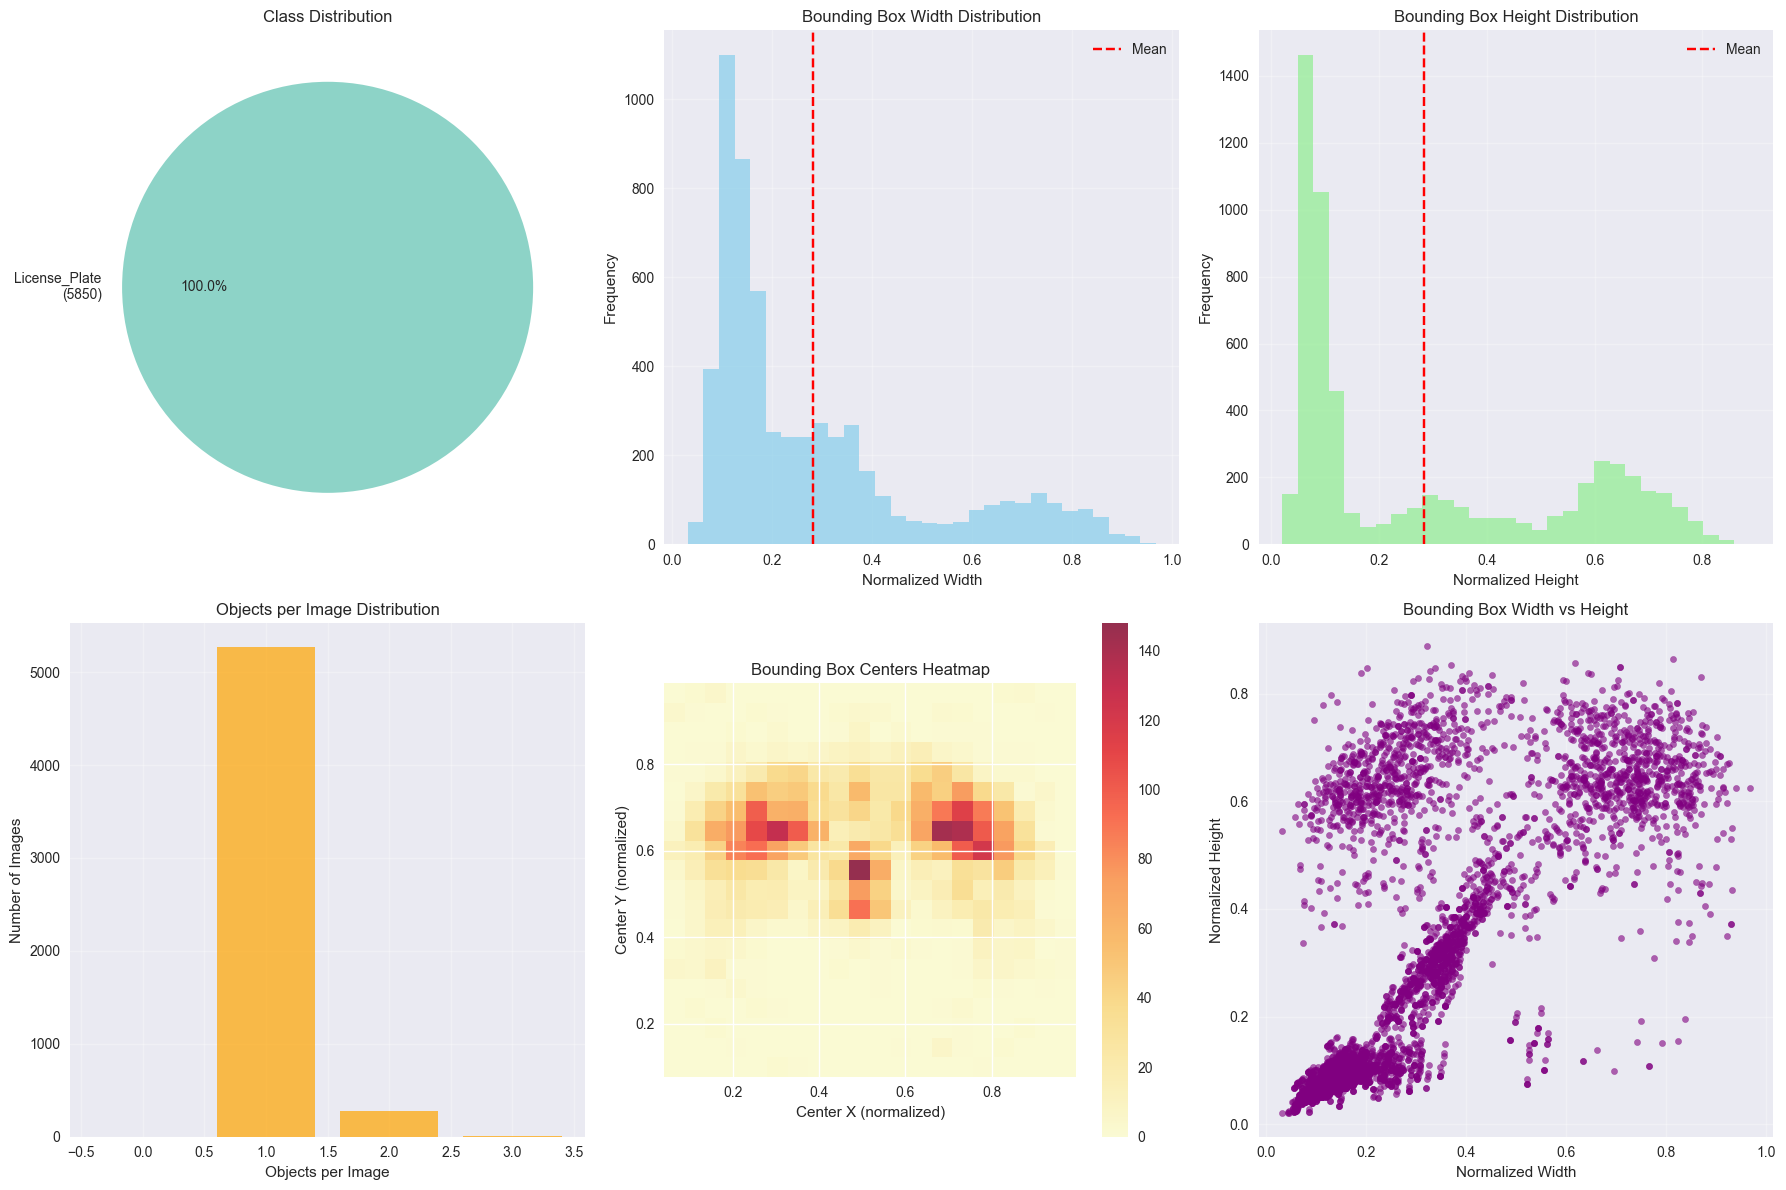


Annotation plots saved to: ..\results\plots\annotation_analysis.png


<Figure size 800x550 with 0 Axes>

In [17]:
def create_annotation_plots(annotation_stats, class_names):
    """Create visualization plots for annotation analysis"""
    if not annotation_stats or len(annotation_stats['bbox_widths']) == 0:
        print("No annotation data available for plotting")
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Class distribution pie chart
    class_counts = []
    class_labels = []
    colors = plt.cm.Set3(np.linspace(0, 1, len(annotation_stats['class_distribution'])))
    
    for class_id, count in annotation_stats['class_distribution'].items():
        class_name = class_names[class_id] if class_id < len(class_names) else f'class_{class_id}'
        class_counts.append(count)
        class_labels.append(f'{class_name}\n({count})')
    
    axes[0,0].pie(class_counts, labels=class_labels, autopct='%1.1f%%', colors=colors)
    axes[0,0].set_title('Class Distribution')
    
    # 2. Bounding box width distribution
    axes[0,1].hist(annotation_stats['bbox_widths'], bins=30, alpha=0.7, color='skyblue')
    axes[0,1].axvline(np.mean(annotation_stats['bbox_widths']), color='red', linestyle='--', label='Mean')
    axes[0,1].set_xlabel('Normalized Width')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Bounding Box Width Distribution')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Bounding box height distribution
    axes[0,2].hist(annotation_stats['bbox_heights'], bins=30, alpha=0.7, color='lightgreen')
    axes[0,2].axvline(np.mean(annotation_stats['bbox_heights']), color='red', linestyle='--', label='Mean')
    axes[0,2].set_xlabel('Normalized Height')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Bounding Box Height Distribution')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Objects per image distribution
    obj_counts = list(range(max(annotation_stats['objects_per_image'])+1))
    obj_frequencies = [annotation_stats['objects_per_image'].count(i) for i in obj_counts]
    
    axes[1,0].bar(obj_counts, obj_frequencies, alpha=0.7, color='orange')
    axes[1,0].set_xlabel('Objects per Image')
    axes[1,0].set_ylabel('Number of Images')
    axes[1,0].set_title('Objects per Image Distribution')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Bounding box centers heatmap
    heatmap, xedges, yedges = np.histogram2d(annotation_stats['center_x'], annotation_stats['center_y'], bins=20)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    im = axes[1,1].imshow(heatmap.T, extent=extent, origin='lower', cmap='YlOrRd', alpha=0.8)
    axes[1,1].set_xlabel('Center X (normalized)')
    axes[1,1].set_ylabel('Center Y (normalized)')
    axes[1,1].set_title('Bounding Box Centers Heatmap')
    plt.colorbar(im, ax=axes[1,1])
    
    # 6. Width vs Height scatter plot
    axes[1,2].scatter(annotation_stats['bbox_widths'], annotation_stats['bbox_heights'], alpha=0.6, s=20, color='purple')
    axes[1,2].set_xlabel('Normalized Width')
    axes[1,2].set_ylabel('Normalized Height')
    axes[1,2].set_title('Bounding Box Width vs Height')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save plots
    plots_dir = Path("../results/plots")
    plots_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(plots_dir / "annotation_analysis.png", dpi=300, bbox_inches='tight')
    print(f"\nAnnotation plots saved to: {plots_dir / 'annotation_analysis.png'}")

# Create annotation plots
if annotation_stats:
    create_annotation_plots(annotation_stats, class_names)

## 10. Generate Data Quality Report

In [18]:
def generate_data_quality_report(structure_analysis, image_stats, annotation_stats, class_names, dataset_config):
    """Generate comprehensive data quality report"""
    from datetime import datetime
    
    report = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "dataset_config": dataset_config,
        "summary": {
            "total_images": 0,
            "total_labels": 0,
            "total_objects": 0,
            "class_names": class_names
        },
        "quality_metrics": {
            "issues_found": [],
            "recommendations": [],
            "quality_score": 0
        },
        "splits_analysis": {},
        "image_statistics": {},
        "annotation_statistics": {}
    }
    
    # Basic summary
    if structure_analysis:
        report["summary"]["total_images"] = structure_analysis["total_images"]
        report["summary"]["total_labels"] = structure_analysis["total_labels"]
        
        # Splits analysis
        for split_name, split_info in structure_analysis["splits"].items():
            report["splits_analysis"][split_name] = {
                "images": split_info["images"],
                "labels": split_info["labels"],
                "match_rate": split_info["labels"] / split_info["images"] if split_info["images"] > 0 else 0,
                "missing_labels": len(split_info["missing_labels"]),
                "missing_images": len(split_info["missing_images"])
            }
    
    # Image statistics
    if image_stats and len(image_stats['widths']) > 0:
        report["image_statistics"] = {
            "dimensions": {
                "width_range": [min(image_stats['widths']), max(image_stats['widths'])],
                "height_range": [min(image_stats['heights']), max(image_stats['heights'])],
                "avg_width": np.mean(image_stats['widths']),
                "avg_height": np.mean(image_stats['heights'])
            },
            "aspect_ratios": {
                "range": [min(image_stats['aspect_ratios']), max(image_stats['aspect_ratios'])],
                "average": np.mean(image_stats['aspect_ratios'])
            },
            "file_sizes_kb": {
                "range": [min(image_stats['file_sizes']), max(image_stats['file_sizes'])],
                "average": np.mean(image_stats['file_sizes'])
            }
        }
    
    # Annotation statistics
    if annotation_stats and len(annotation_stats['bbox_widths']) > 0:
        total_objects = sum(annotation_stats['class_distribution'].values())
        report["summary"]["total_objects"] = total_objects
        
        class_dist = {}
        for class_id, count in annotation_stats['class_distribution'].items():
            class_name = class_names[class_id] if class_id < len(class_names) else f'class_{class_id}'
            class_dist[class_name] = {
                "count": count,
                "percentage": count / total_objects * 100
            }
        
        report["annotation_statistics"] = {
            "class_distribution": class_dist,
            "bbox_stats": {
                "avg_width": np.mean(annotation_stats['bbox_widths']),
                "avg_height": np.mean(annotation_stats['bbox_heights']),
                "avg_area": np.mean(annotation_stats['bbox_areas'])
            },
            "objects_per_image": {
                "average": np.mean(annotation_stats['objects_per_image']),
                "range": [min(annotation_stats['objects_per_image']), max(annotation_stats['objects_per_image'])]
            }
        }
    
    # Quality assessment
    quality_score = 100
    issues = []
    recommendations = []
    
    # Check for structural issues
    if structure_analysis and structure_analysis['issues']:
        issues.extend(structure_analysis['issues'])
        quality_score -= len(structure_analysis['issues']) * 10
    
    # Check dataset size
    if report["summary"]["total_images"] < 1000:
        issues.append(f"Dataset size is small ({report['summary']['total_images']} images). Consider adding more data.")
        quality_score -= 15
    
    # Check class balance
    if "class_distribution" in report["annotation_statistics"]:
        class_percentages = [info["percentage"] for info in report["annotation_statistics"]["class_distribution"].values()]
        if max(class_percentages) > 90:
            issues.append("Severe class imbalance detected. Consider balancing the dataset.")
            quality_score -= 20
        elif max(class_percentages) > 80:
            issues.append("Moderate class imbalance detected.")
            quality_score -= 10
    
    # Check image dimensions consistency
    if image_stats and len(image_stats['widths']) > 0:
        width_std = np.std(image_stats['widths'])
        height_std = np.std(image_stats['heights'])
        
        if width_std > 500 or height_std > 500:
            issues.append("High variation in image dimensions. Consider resizing for consistent training.")
            quality_score -= 5
    
    # Recommendations
    if report["summary"]["total_images"] < 1500:
        recommendations.append("Consider augmenting the dataset to reach 1500+ images for better training results.")
    
    if image_stats and np.mean(image_stats['widths']) < 640:
        recommendations.append("Average image size is below 640px. Consider using higher resolution images.")
    
    recommendations.extend([
        "Verify that license plate annotations are accurate and complete.",
        "Check for diverse lighting conditions and viewing angles.",
        "Ensure Indonesian license plate formats are well represented."
    ])
    
    report["quality_metrics"] = {
        "issues_found": issues,
        "recommendations": recommendations,
        "quality_score": max(0, quality_score)  # Ensure non-negative
    }
    
    return report

# Generate report
data_quality_report = generate_data_quality_report(
    structure_analysis, image_stats, annotation_stats, class_names, dataset_config
)

# Display report summary
print("\n📋 Data Quality Report Summary")
print("=" * 50)
print(f"Generated: {data_quality_report['timestamp']}")
print(f"Total Images: {data_quality_report['summary']['total_images']}")
print(f"Total Objects: {data_quality_report['summary']['total_objects']}")
print(f"Quality Score: {data_quality_report['quality_metrics']['quality_score']}/100")

if data_quality_report['quality_metrics']['issues_found']:
    print(f"\n⚠️  Issues Found ({len(data_quality_report['quality_metrics']['issues_found'])}):")
    for issue in data_quality_report['quality_metrics']['issues_found']:
        print(f"  - {issue}")

print(f"\n💡 Recommendations ({len(data_quality_report['quality_metrics']['recommendations'])}):")
for rec in data_quality_report['quality_metrics']['recommendations'][:3]:  # Show first 3
    print(f"  - {rec}")

# Save report
reports_dir = Path("../results/reports")
reports_dir.mkdir(parents=True, exist_ok=True)

with open(reports_dir / "data_quality_report.json", 'w') as f:
    json.dump(data_quality_report, f, indent=2, default=str)

print(f"\n📄 Full report saved to: {reports_dir / 'data_quality_report.json'}")


📋 Data Quality Report Summary
Generated: 2025-08-05 14:08:15
Total Images: 11106
Total Objects: 5850
Quality Score: 80/100

⚠️  Issues Found (1):
  - Severe class imbalance detected. Consider balancing the dataset.

💡 Recommendations (3):
  - Verify that license plate annotations are accurate and complete.
  - Check for diverse lighting conditions and viewing angles.
  - Ensure Indonesian license plate formats are well represented.

📄 Full report saved to: ..\results\reports\data_quality_report.json


## 11. Indonesian License Plate Pattern Analysis

In [20]:
# Indonesian License Plate Pattern Reference
print("🚗 Indonesian License Plate Patterns Reference")
print("=" * 50)

indonesian_patterns = {
    "Standard Format": "[Area Code] [Number] [Suffix]",
    "Examples": [
        "B 1234 ABC (Jakarta)",
        "D 5678 XY (Bandung)", 
        "L 9012 DEF (Surabaya)",
        "AA 1234 BB (Kedu/Magelang)"
    ],
    "Area Codes": {
        "B": "Jakarta",
        "D": "Bandung", 
        "F": "Bogor",
        "L": "Surabaya",
        "N": "Malang",
        "AA": "Kedu (Magelang)",
        "AB": "Yogyakarta",
        "AD": "Solo"
    }
}

for category, info in indonesian_patterns.items():
    print(f"\n{category}:")
    if isinstance(info, dict):
        for key, value in info.items():
            print(f"  {key}: {value}")
    elif isinstance(info, list):
        for item in info:
            print(f"  - {item}")
    else:
        print(f"  {info}")

print("\n📝 Notes for Training:")
print("  - Focus on detecting plate regions (bounding boxes)")
print("  - OCR (text recognition) will be handled separately with PaddleOCR")
print("  - Model should work with various plate colors and sizes")
print("  - Consider motorcycle plates (smaller, different aspect ratio)")

🚗 Indonesian License Plate Patterns Reference

Standard Format:
  [Area Code] [Number] [Suffix]

Examples:
  - B 1234 ABC (Jakarta)
  - D 5678 XY (Bandung)
  - L 9012 DEF (Surabaya)
  - AA 1234 BB (Kedu/Magelang)

Area Codes:
  B: Jakarta
  D: Bandung
  F: Bogor
  L: Surabaya
  N: Malang
  AA: Kedu (Magelang)
  AB: Yogyakarta
  AD: Solo

📝 Notes for Training:
  - Focus on detecting plate regions (bounding boxes)
  - OCR (text recognition) will be handled separately with PaddleOCR
  - Model should work with various plate colors and sizes
  - Consider motorcycle plates (smaller, different aspect ratio)


## Summary and Next Steps

This notebook provides comprehensive analysis of the Indonesian license plate dataset including:

### ✅ Completed Analysis:
- Dataset structure verification
- Image statistics (dimensions, aspect ratios, file sizes)
- Annotation quality assessment
- Class distribution analysis
- Data quality report generation
- Indonesian license plate pattern reference

### 📊 Key Outputs:
- Sample images with annotations visualized
- Statistical plots saved to `results/plots/`
- Quality report saved to `results/reports/`
- Issues and recommendations identified

### 🎯 Next Steps:
1. **Review the data quality report** and address any critical issues
2. **Proceed to Notebook 03** for data preparation and preprocessing
3. **Clean and augment data** based on findings from this analysis
4. **Prepare YOLO configuration** files for training

### 🔄 If Issues Found:
- **Missing labels**: Remove images without corresponding labels
- **Class imbalance**: Consider data augmentation or resampling
- **Inconsistent dimensions**: Implement consistent resizing strategy
- **Quality issues**: Manual review and cleanup of problematic samples

The dataset is now thoroughly analyzed and ready for preprocessing in the next notebook.